<a href="https://www.kaggle.com/code/azratuni/financial-time-series-analysis?scriptVersionId=167999168" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import pylab
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.api import AutoReg
from scipy.stats.distributions import chi2
import seaborn as sns
sns.set()

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.simplefilter("ignore")

/kaggle/input/index2018/Index2018.csv
/kaggle/input/random-walk/RandWalk.csv


In [2]:
df = pd.read_csv('/kaggle/input/index2018/Index2018.csv')

# Examining the data

In [3]:
df.head()

,date,spx,dax,ftse,nikkei
0,07/01/1994,469.90,2224.95,3445.98,18124.01
1,10/01/1994,475.27,2225.00,3440.58,18443.44
2,11/01/1994,474.13,2228.10,3413.77,18485.25
3,12/01/1994,474.17,2182.06,3372.02,18793.88
4,13/01/1994,472.47,2142.37,3360.01,18577.26


**Market indexes in the data:**
* S&P 500 - spx (USA)
* DAX 30 - dax (Germany)
* FTSE 100 - ftse (London - UK)
* NIKKEI 225 - nikkei (Japan)

**The numbers following each index represent the number of companies included in the portfolio. So, S&P 500 has 500 companies included in the portfolio.**

In [4]:
df.shape

(6269, 5)

In [5]:
df.describe()

,spx,dax,ftse,nikkei
count,6269.000000,6269.000000,6269.000000,6269.000000
mean,1288.127542,6080.063363,5422.713545,14597.055700
std,487.586473,2754.361032,1145.572428,4043.122953
min,438.920000,1911.700000,2876.600000,7054.980000
25%,990.671905,4069.350000,4486.100000,10709.290000
50%,1233.420000,5773.340000,5662.430000,15028.170000
75%,1459.987747,7443.070000,6304.250000,17860.470000
max,2872.867839,13559.600000,7778.637689,24124.150000


**We can see that the mean value of spx is several times lower than other indexes. The max value of spx is also lower than the min value of ftse and nikkei.** 

**The values of dax and ftse are similar. The values of spx are a lot smaller and the values of nikkei are a lot larger compared to other values.**

In [6]:
df.isna().sum()

date      0
spx       0
dax       0
ftse      0
nikkei    0
dtype: int64

# Length of time period

In [7]:
df.date.describe() #this gives meaningless reasults when the data column is not in datetime format

count           6269
unique          6269
top       07/01/1994
freq               1
Name: date, dtype: object

In [8]:
df.date = pd.to_datetime(df.date, dayfirst = True)

In [9]:
df.head()

,date,spx,dax,ftse,nikkei
0,1994-01-07,469.90,2224.95,3445.98,18124.01
1,1994-01-10,475.27,2225.00,3440.58,18443.44
2,1994-01-11,474.13,2228.10,3413.77,18485.25
3,1994-01-12,474.17,2182.06,3372.02,18793.88
4,1994-01-13,472.47,2142.37,3360.01,18577.26


In [10]:
df.date.describe()

count                             6269
mean     2006-01-14 19:36:59.492742144
min                1994-01-07 00:00:00
25%                2000-01-11 00:00:00
50%                2006-01-12 00:00:00
75%                2012-01-19 00:00:00
max                2018-01-29 00:00:00
Name: date, dtype: object

In [11]:
df.set_index("date", inplace = True)

# Data visualization

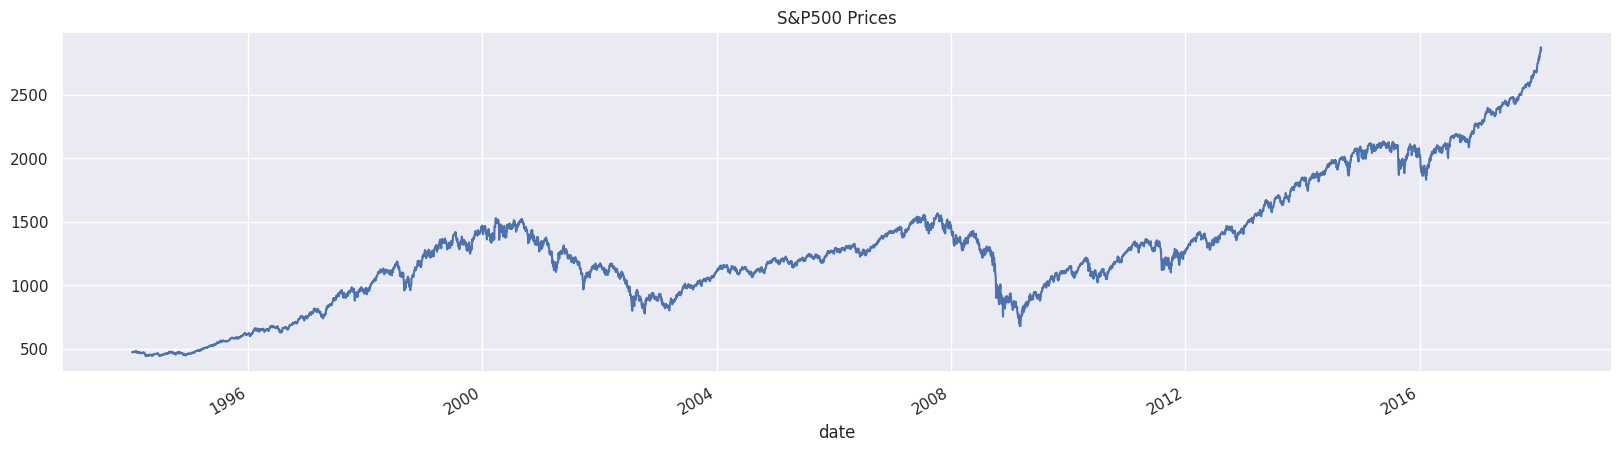

In [12]:
df.spx.plot(figsize = (20,5), title = 'S&P500 Prices')
plt.show()

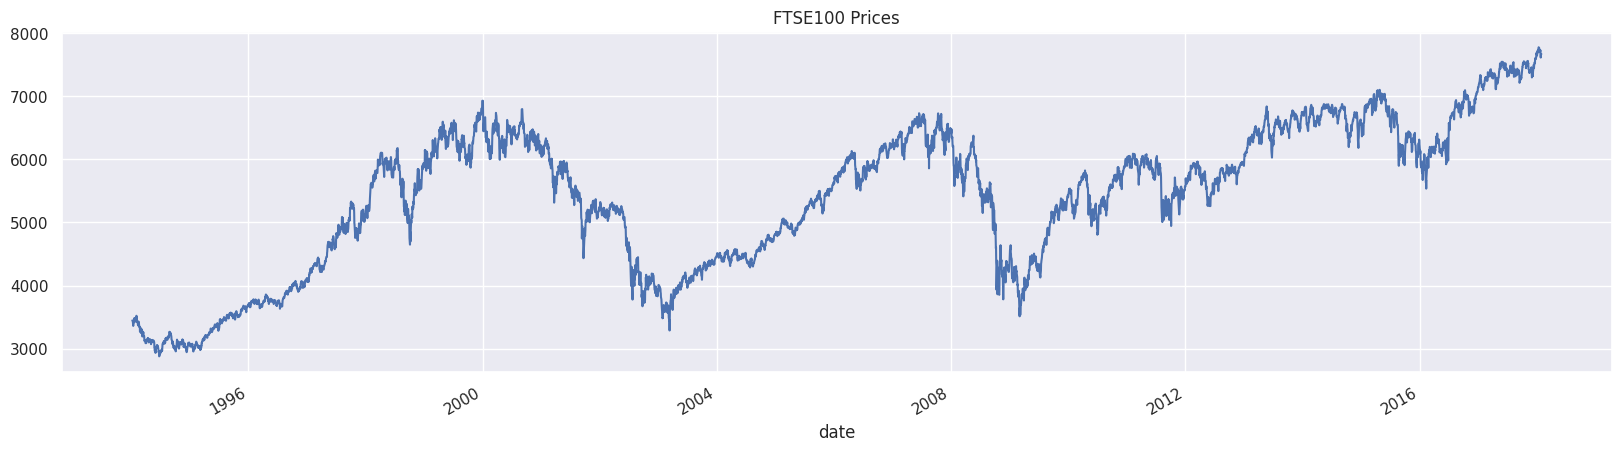

In [13]:
df.ftse.plot(figsize = (20,5), title = 'FTSE100 Prices')
plt.show()

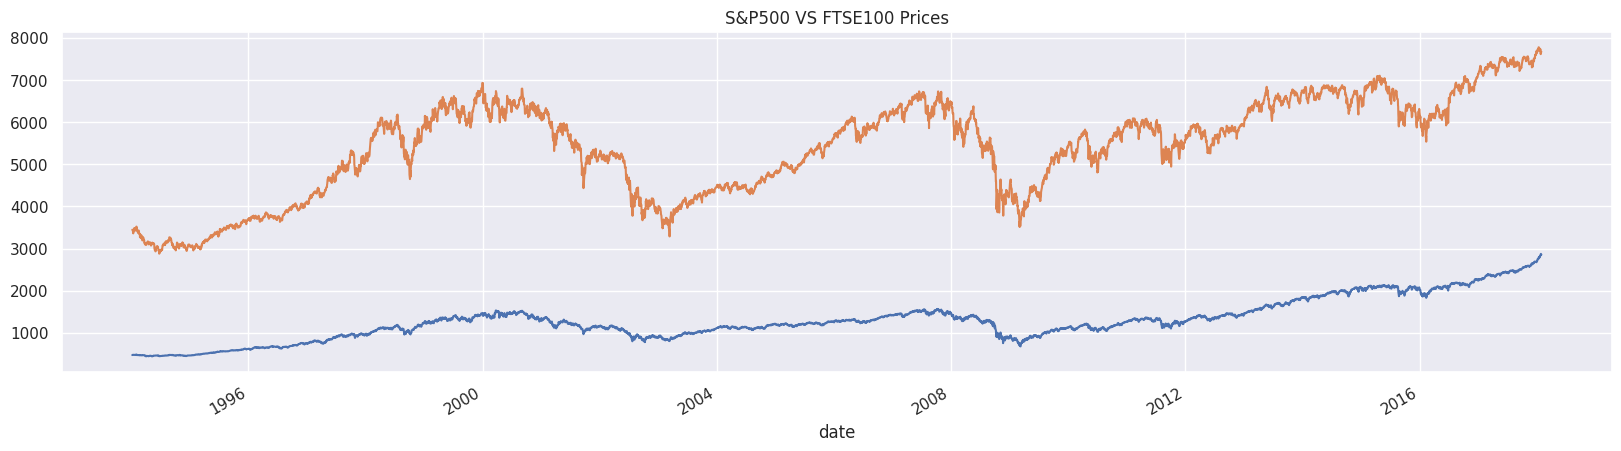

In [14]:
df.spx.plot(figsize = (20,5), title = 'S&P500 Prices')
df.ftse.plot(figsize = (20,5), title = 'FTSE100 Prices')
plt.title("S&P500 VS FTSE100 Prices")
plt.show()

**We can see that the FTSE values are much greater that S&P values. But their trend movement is similar. The S&P looks much more flatter than FTSE. This could suggest that S&P is much more stable but that would be misleading. In reality, the S&P and FTSE values have vastly different magnitudes.** 

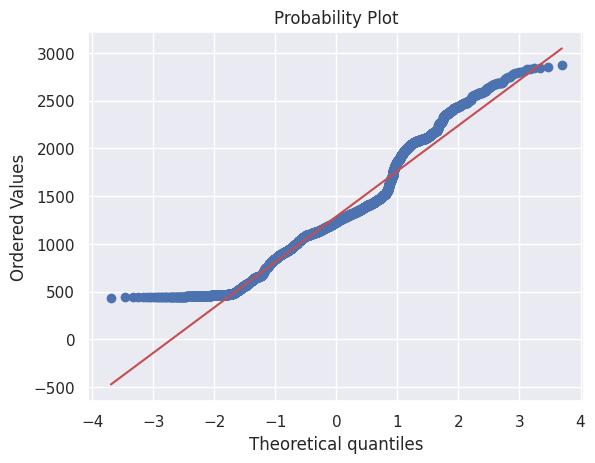

In [15]:
scipy.stats.probplot(df.spx, plot = pylab)
pylab.show()

**As we can see, the spx data is not normally distributed as it does not follow the red line all the way, which represents how the data should look like if normally distributed.** 

# Setting data frequency

In [16]:
df = df.asfreq('d') #'d' - daily

In [17]:
df.head() #January 8th and 9th is NaN because these dates were not in the original dataset

,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-08,NaN,NaN,NaN,NaN
1994-01-09,NaN,NaN,NaN,NaN
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25


In [18]:
df = df.asfreq('b') #'b' - business days, not taking weekends

In [19]:
df.head()

,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25
1994-01-12,474.17,2182.06,3372.02,18793.88
1994-01-13,472.47,2142.37,3360.01,18577.26


# Handling missing values

In [20]:
df.isna().sum() #setting the frequency to business days creates 8 days with null values

spx       8
dax       8
ftse      8
nikkei    8
dtype: int64

In [21]:
df.spx = df.spx.fillna(method = 'ffill') #front fill

In [22]:
df.ftse = df.ftse.fillna(method = 'bfill') #back fill

In [23]:
df.dax = df.dax.fillna(value = df.dax.mean()) #filling with average values

In [24]:
df.nikkei = df.nikkei.fillna(value = df.nikkei.mean()) #filling with average values

# Analyze how S&P 500 performs

In [25]:
df_spx = df
df_spx = df_spx.drop(['dax', 'ftse', 'nikkei'], axis=1)
df_spx.head()

,spx
date,
1994-01-07,469.90
1994-01-10,475.27
1994-01-11,474.13
1994-01-12,474.17
1994-01-13,472.47


In [26]:
# the data will be 80-20 train-test
# to find out the exact cut off point
size = int(len(df_spx)*0.8)

In [27]:
df_train = df_spx.iloc[:size]

In [28]:
df_test = df_spx.iloc[size:]

In [29]:
df_train.tail()

,spx
date,
2013-04-01,1562.173837
2013-04-02,1570.252238
2013-04-03,1553.686978
2013-04-04,1559.979316
2013-04-05,1553.278930


In [30]:
df_test.head()

,spx
date,
2013-04-08,1563.071269
2013-04-09,1568.607909
2013-04-10,1587.731827
2013-04-11,1593.369863
2013-04-12,1588.854623


# White Noise

In [31]:
wn = np.random.normal(loc = df_train.spx.mean(), scale = df_train.spx.std(), size = len(df_train))

In [32]:
df_train['wn'] = wn

In [33]:
df_train.describe()

,spx,wn
count,5021.000000,5021.000000
mean,1091.651926,1095.896167
std,292.559287,294.611071
min,438.920000,59.363512
25%,914.620000,892.985579
50%,1144.650000,1089.129924
75%,1316.280729,1298.794762
max,1570.252238,2163.705629


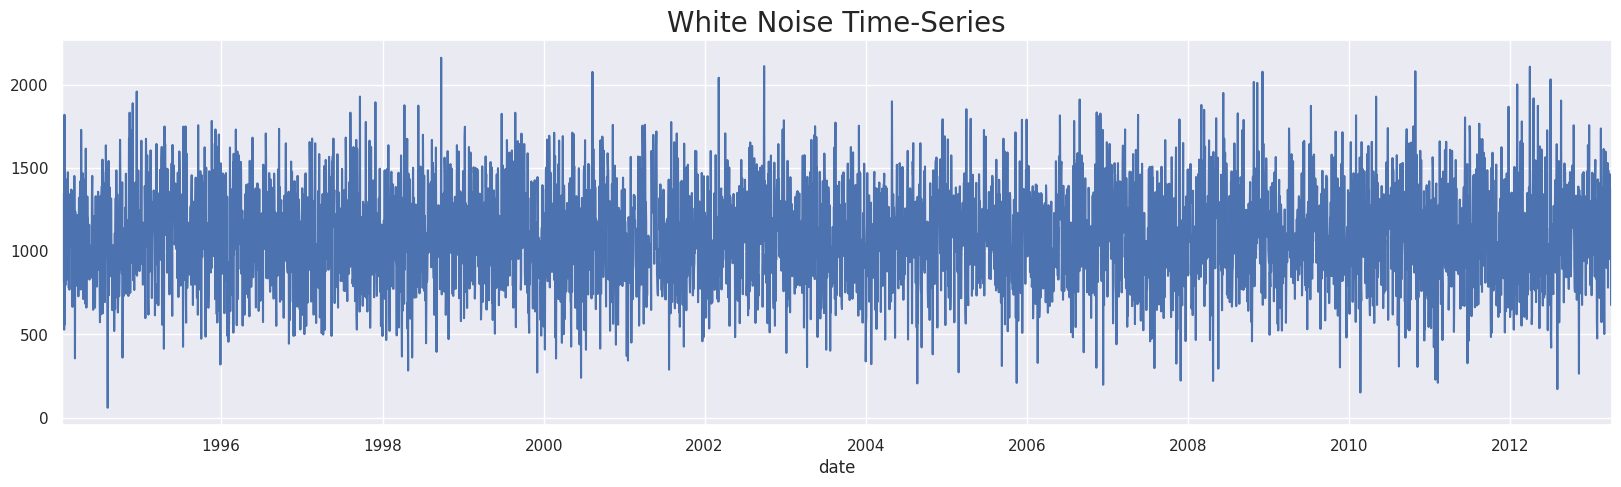

In [34]:
df_train.wn.plot(figsize = (20,5))
plt.title("White Noise Time-Series", size = 20)
plt.show()

**Above we can see that most values are densely packed around the mean value**

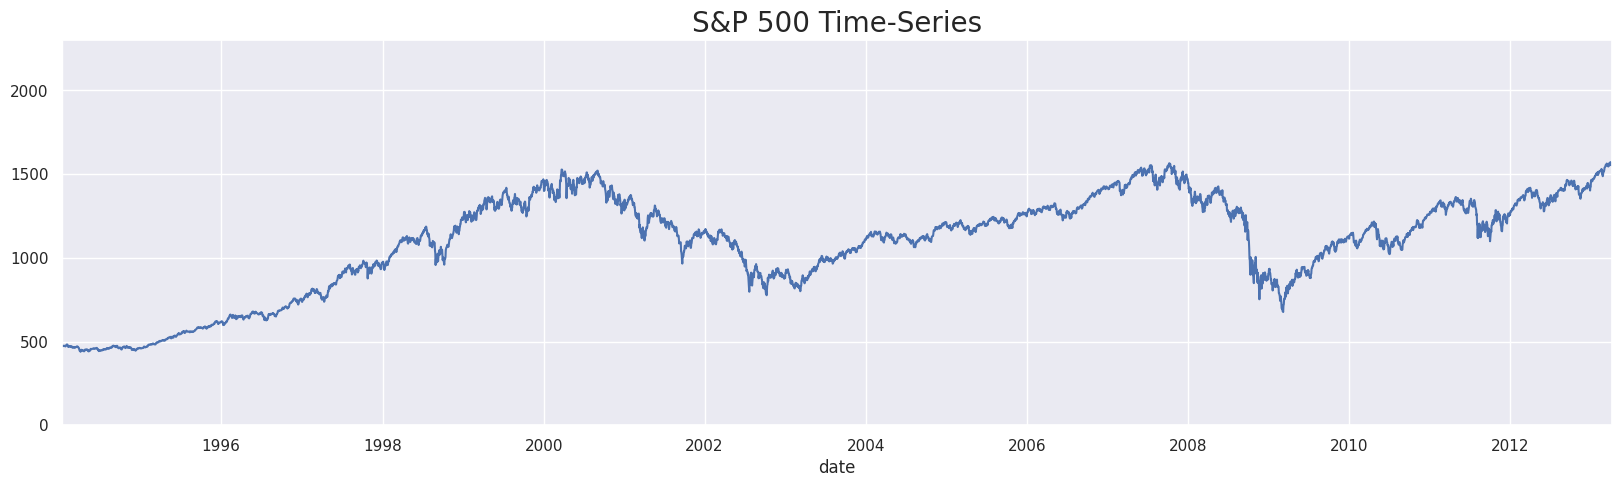

In [35]:
df_train.spx.plot(figsize = (20,5))
plt.title("S&P 500 Time-Series", size = 20)
plt.ylim(0,2300)
plt.show()

**We can see the vast difference betweern the white noise and S&P 500 graph.**

# Random Walk

In [36]:
rw = pd.read_csv('/kaggle/input/random-walk/RandWalk.csv')
rw.date = pd.to_datetime(rw.date, dayfirst = True)

In [37]:
rw.set_index('date',inplace = True)
rw =rw.asfreq('b')
rw.describe()

,price
count,5021.000000
mean,1269.944293
std,444.216793
min,585.483034
25%,931.550429
50%,1156.363045
75%,1488.362029
max,2715.508720


In [38]:
df_train['rw'] = rw.price 
df_train.head()

,spx,wn,rw
date,,,
1994-01-07,469.90,923.769845,1122.139662
1994-01-10,475.27,818.042227,1080.347860
1994-01-11,474.13,1028.310815,1082.095245
1994-01-12,474.17,1342.157849,1083.639265
1994-01-13,472.47,1065.666939,1067.146255


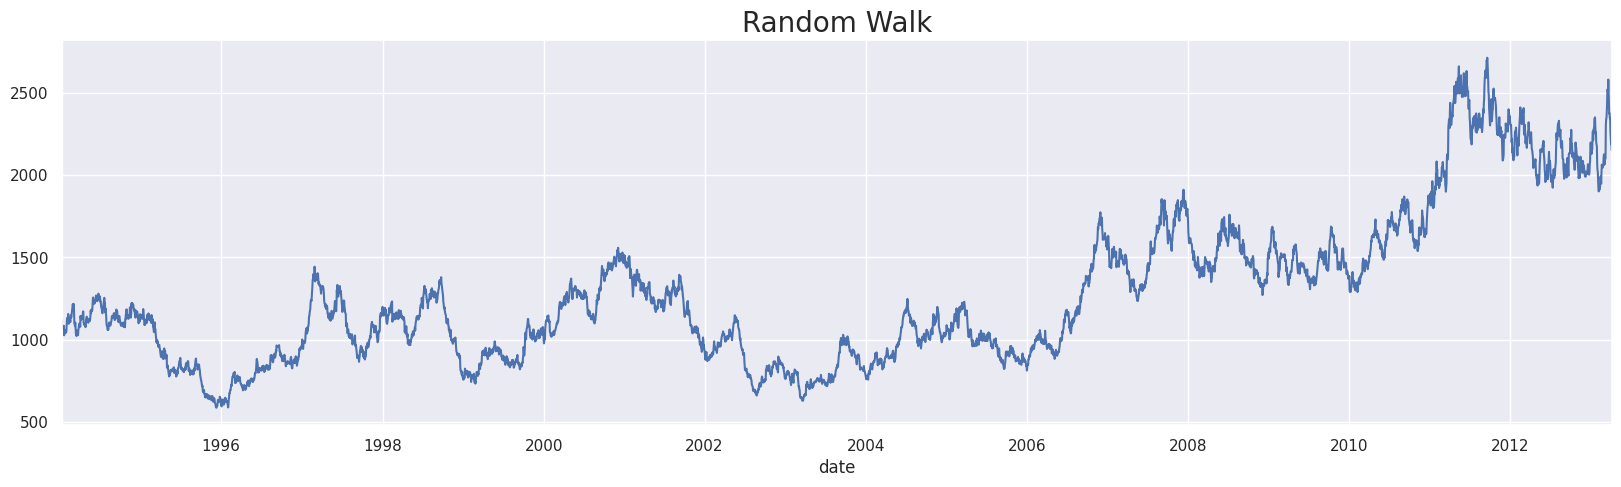

In [39]:
df_train.rw.plot(figsize = (20,5))
plt.title("Random Walk", size = 20)
plt.show()

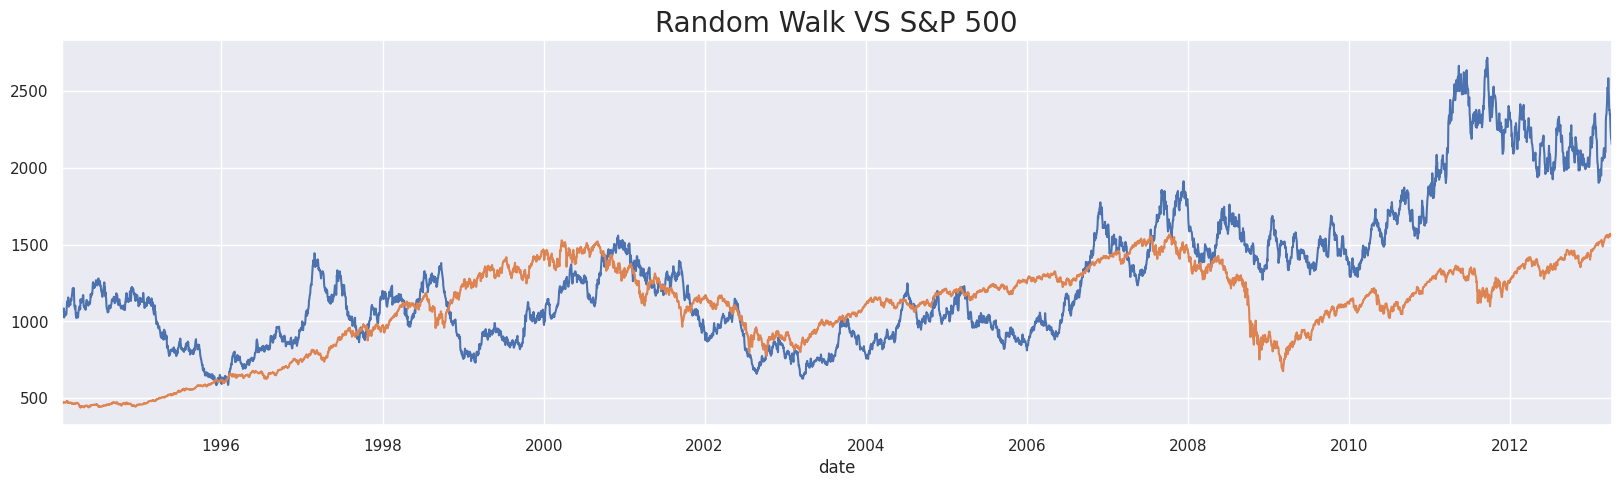

In [40]:
# comparing random walk and S&P 500 graphs because they appear similar
df_train.rw.plot(figsize = (20,5))
df_train.spx.plot()
plt.title("Random Walk VS S&P 500", size = 20)
plt.show()

**The two timeseries look somewhat similar. Both have small variations between consecutive time periods. Both have cyclical increases and decreases in short periods of time.** 

**If a timeseries resembles a random walk, the prices can't be predicted with great accuracy.**

# Stationarity

In [41]:
# Augmented Dickey-Fuller Test
sts.adfuller(df_train.spx)

(-1.7369847452352458,
 0.41216456967706105,
 18,
 5002,
 {'1%': -3.431658008603046,
  '5%': -2.862117998412982,
  '10%': -2.567077669247375},
 39904.880607487445)

**Let's breakdown and understand the output above,**
* The first line (-1.7369847452352458) is the test statistic from running the test
* The second line (0.41216456967706105) is the P-value associated with the T-statistic. P-value of 0.41 suggests there is roughly a 40% chance of not rejecting the Null. So, we can't confirm the data is stationary
* The third line (18) represents the number of lags used in the regression when determining the T-statistic. In this case, there's 18, so, there's some autocorrelation going back 18 periods. This has to be taken into account when picking an appropriate model. 
* The forth line (5002) expresses the number of observations used in the analysis. This value depends on the number of lags used in the regression so the two should usually add up to the size of the dataset. 
* The 1,5 and 10 percent critical values from the Dickey-Fuller Table, we can choose any of them as levels of significance in our analysis
* The last line (39904.880607487445) estimates the maximized information criteria provided there is some apparent autocorrelation. The lower the value is the easier it is to make predictions for the future. 

**The test statistic (T-statistic) is greater than each of the critical values. Thus, for all of these levels of significance, we do not find sufficient evidence of stationarity in the dataset.**

In [42]:
# Augmented Dickey-Fuller Test on White Noise
sts.adfuller(df_train.wn)

(-39.47431651872278,
 0.0,
 2,
 5018,
 {'1%': -3.4316538358533277,
  '5%': -2.8621161549128313,
  '10%': -2.567076687880585},
 70880.15380846952)

**We see a P-value close to zero, no lags being part of the regression as there is no autocorrelation in White Noise.**

**White Noise is a stationary process.** 

In [43]:
# Augmented Dickey-Fuller Test on Random Walk
sts.adfuller(df_train.rw)

(-1.3286073927689719,
 0.6159849181617385,
 24,
 4996,
 {'1%': -3.4316595802782865,
  '5%': -2.8621186927706463,
  '10%': -2.567078038881065},
 46299.333497595144)

**The P-value is around 0.62, we do not find sufficient evidence of stationarity of this timeseries. Based on the P-value, there is more than a 60% chance that the data comes from a non-stationary process.** 

**We expect Random Walks to be non-stationary process. Hence, the results satisfy our expectations.**

# Seasonality

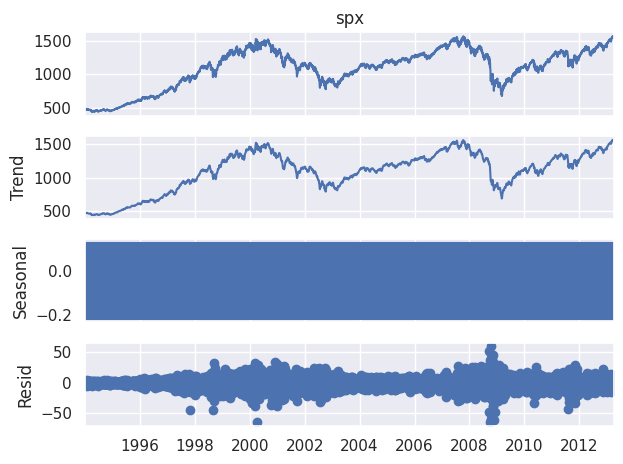

In [44]:
#Additive Decomposition
s_dec_additive = seasonal_decompose(df_train.spx, model = 'additive')
s_dec_additive.plot()
plt.show()

**The 1st plot is the Observed series. We can see that the Trend closely resembles the Observed series. Because the decomposition function uses the previous period values as a trend setter. We have already determined that the current period prices are the best predictor for the next period's prices. If we observe seasonal patterns, we will have other prices as better predictors.** 

**For example, if prices are higher at the beginning of the month compared to the end, we'll be better off using values from some 30 periods ago than from one period ago.** 

**The Trend part of the decomposition explains most of the variability of the data. The Seasonal plot looks like a rectangle. This happens when the values are constantly oscillating back and forth (in our case, between negative 0.2 and positive 0.1 for every period) and the figure size is too small. Therefore, there is no concrete cyclical pattern determined by using naive decomposition.** 

**The Residuals are the errors of our model estimates. Essentially, they are the difference between true values and predictions for any period. The residuals vary greatly around the turn of the century (2000) and around 2008.** 

**The results of the Additive Decomposition suggest no seasonality in the data.** 

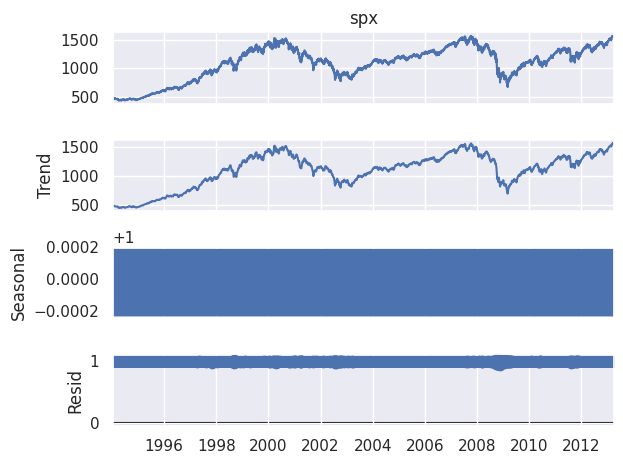

In [45]:
# Multiplicative Decomposition
s_dec_multiplicative = seasonal_decompose(df_train.spx, model = 'multiplicative')
s_dec_multiplicative.plot()
plt.show()

**Multiplicative Decomposition gives very similar results to Additive Decomposition. The Seasonal sequence has no clear pattern once again and the Trend closely resembles the Observed series. Thus we have furthur proof there is no seasonality among S&P 500 prices.** 

# Auto Correlation Function (ACF)

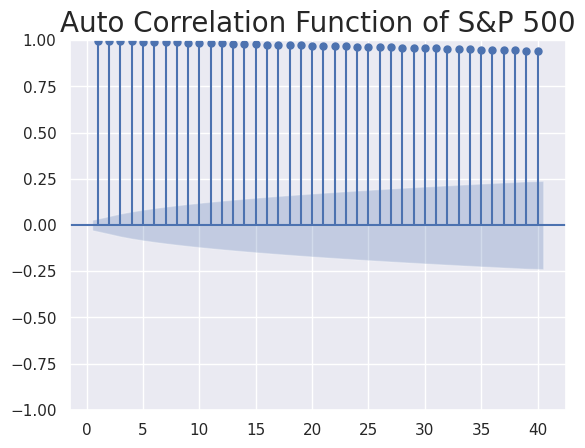

In [46]:
#lags = 40 means the last 40 periods before the current one
# the "zero" argument indicates whether we include current period values in the graph
sgt.plot_acf(df_train.spx, lags = 40, zero = False) 
plt.title("Auto Correlation Function of S&P 500", size = 20)
plt.show()

**The x-axis is the values of lag. The numbers on y-axis indicate the possible values for the autocorrelation coefficient. Correlation can only take values between negative 1 and 1. The thin line across the plot represents the autocorrelation between the time series and a lagged copy of itself.** 

**The first line indicates autocorrelation one time period ago. The 2nd line represents the coefficient value for two periods ago and so on.** 

**The blue area around the x-axis represents significance. The values situated outside are significantly different from zero. Which suggests the existance of autocorrelation for that specific lag. This area expands as lag values increase. The greater the distance in time, the more unlikely it is that this autocorrelation persists.** 

**All the lines are higher than the blue region, this suggests the coefficients are significant. Which is an indicator of time dependence in the data. We can see that the autocorrelation barely diminishes as the lags increase, this suggests that the prices even a month back can still serve as decent estimators.** 

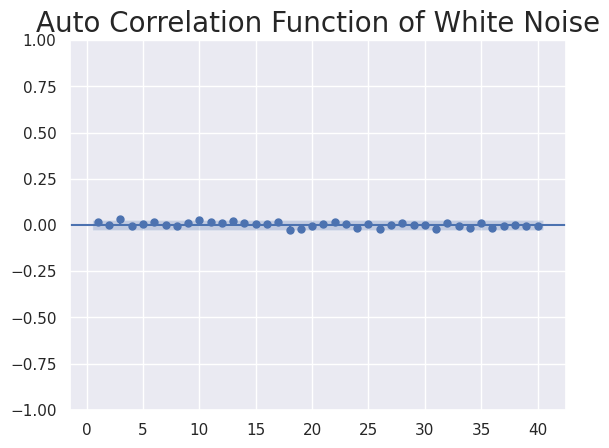

In [47]:
# ACF of White Noise
sgt.plot_acf(df_train.wn, lags = 40, zero = False) 
plt.title("Auto Correlation Function of White Noise", size = 20)
plt.show()

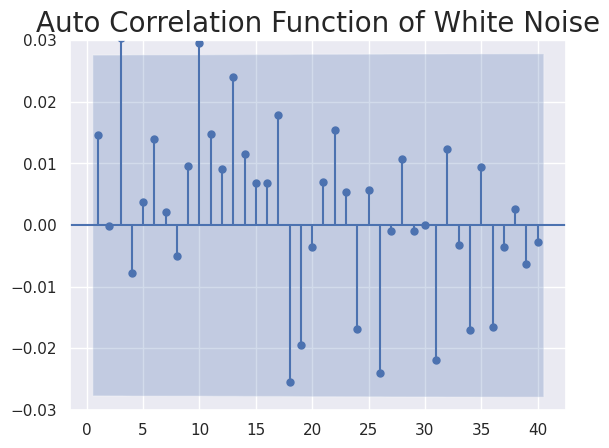

In [48]:
sgt.plot_acf(df_train.wn, lags = 40, zero = False) 
plt.ylim(-0.03,0.03)
plt.title("Auto Correlation Function of White Noise", size = 20)
plt.show()

**ACF for White Noise is vastly different from the ACF of S&P 500. There are values going either way, so there are patterns of positive and negative autocorrelation. All the lines fall within the blue area. Thus the coefficients are not significant across the entire plot. This suggests there is no autocorrelation for any lag which is one of the assumptions of White Noise data.** 

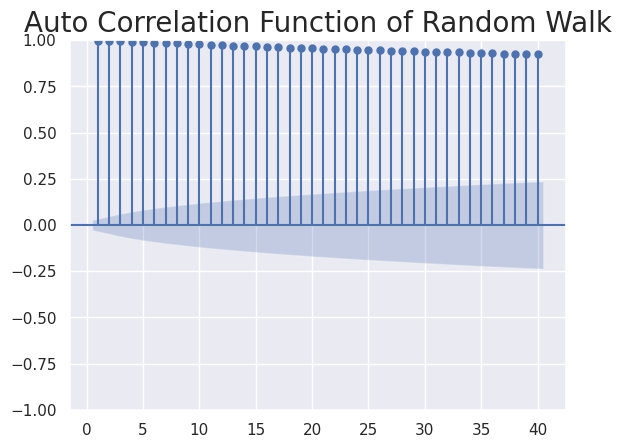

In [49]:
# ACF of Random Walk
sgt.plot_acf(df_train.rw, lags = 40, zero = False) 
plt.title("Auto Correlation Function of Random Walk", size = 20)
plt.show()

**The ACF of Random Walk is similar to the ACF of S&P 500.** 

# Partial Auto Correlation Function (PACF)

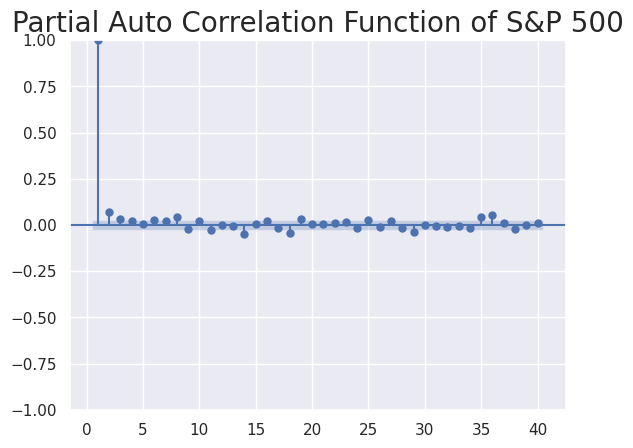

In [50]:
#lags = 40 means the last 40 periods before the current one
# the "zero" argument indicates whether we include current period values in the graph
# OLS - Order of Least Squares
sgt.plot_pacf(df_train.spx, lags = 40, zero = False, method = ('ols')) 
plt.title("Partial Auto Correlation Function of S&P 500", size = 20)
plt.show()

**Only the first several elements are significantly different from zero. A tremendous contrast to the ACF plot where all values were significant. Some of the values like the 9th lag are negative, which means that higher values 9 periods ago result in lower values today and vice-versa.** 

**The vast difference with ACF comes from how PACF works, it cancels out all additional channels in which a previous period value affects the present one.** 

**ACF and PACF values for the first lag should be identical. Because there are no other channels through which past values can affect present values.** 

**Most values after the 3rd lag are in the blue area, this means they are not significantly different from zero. So, the numeric values attached to them are not important. Since we can assume they're all essentially zero, being positive or negative is somewhat random without any lasting effects.** 

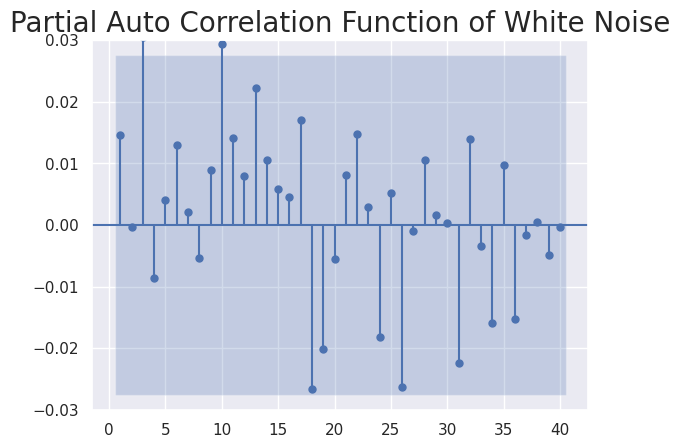

In [51]:
sgt.plot_pacf(df_train.wn, lags = 40, zero = False, method = ('ols'))
plt.ylim(-0.03,0.03)
plt.title("Partial Auto Correlation Function of White Noise", size = 20)
plt.show()

**Most of the values aren't significantly different from zero. Some of the coefficients can end up outside the blue area and seem significant but that is completely random. This aligns with our previous assumption that no autocorrelation exists in White Noise.** 

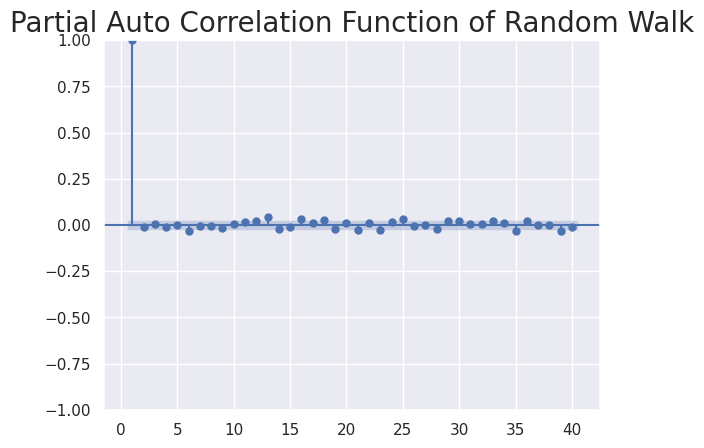

In [52]:
sgt.plot_pacf(df_train.rw, lags = 40, zero = False, method = ('ols'))
#plt.ylim(-0.03,0.03)
plt.title("Partial Auto Correlation Function of Random Walk", size = 20)
plt.show()

**The PACF of Random Walk is also similar to the PACF of S&P 500.** 


# The AR(1) model

In [53]:
lag_order = 1 # Adjust this based on the ACF plot
model_ar_1 = AutoReg(df_train.spx, lags=lag_order)
results_ar_1 = model_ar_1.fit()


In [54]:
results_ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                    spx   No. Observations:                 5021
Model:                     AutoReg(1)   Log Likelihood              -20088.064
Method:               Conditional MLE   S.D. of innovations             13.232
Date:                Wed, 20 Mar 2024   AIC                          40182.129
Time:                        15:04:06   BIC                          40201.692
Sample:                    01-10-1994   HQIC                         40188.984
                         - 04-05-2013                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5542      0.722      2.154      0.031       0.140       2.968
spx.L1         0.9988      0.001   1564.180      0.000       0.998       1.000
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0012           +0.0000j            1.0012            0.0000
-----------------------------------------------------------------------------
"""

**AR(1) model eqn:**

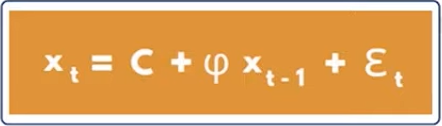

**AR(1) uses only the immediate past observation to predict the current one. The log likelihood value is -20088.264, which measures how well the model fits the data (higher values indicate better fit).**

**The coefficient of the constant term (‘const’) -> "C" is 1.5542. If all other variables were zero, ‘spx’ would be expected to have this value on average. The standard error (std err) associated with this coefficient estimate is 0.722, indicating precision. It means how far away, on average, the model's predictions are from the true values. The z-statistic (associated test statistics or T-statistics for significance) tests whether coefficients are significantly different from zero. For ‘const’, the z-statistic is 2.154, suggesting significance.**

**The last two columns represent the critical values for the 95% confidence interval. If zero is not a part of it, we can confirm that the coefficients are significant.**

**The coefficient for spx.L1 (the first lag of ‘spx’) -> "Phi1" is very close to one (0.9988). This indicates strong persistence over time—the changes in the previous period almost equally affect the current period.**

**Let's try fitting a more complex model.**

# Higher lag AR models

In [55]:
model_ar_2 = AutoReg(df_train.spx, lags=2)
results_ar_2 = model_ar_2.fit()

In [56]:
model_ar_3 = AutoReg(df_train.spx, lags=3)
results_ar_3 = model_ar_3.fit()

In [57]:
model_ar_4 = AutoReg(df_train.spx, lags=4)
results_ar_4 = model_ar_4.fit()

In [58]:
model_ar_5 = AutoReg(df_train.spx, lags=5)
results_ar_5 = model_ar_5.fit()

In [59]:
model_ar_6 = AutoReg(df_train.spx, lags=6)
results_ar_6 = model_ar_6.fit()

In [60]:
model_ar_7 = AutoReg(df_train.spx, lags=7)
results_ar_7 = model_ar_7.fit()

In [61]:
model_ar_8 = AutoReg(df_train.spx, lags=8)
results_ar_8 = model_ar_8.fit()

# Log-likelihood ratio test (LLR)

In [62]:
# mod_1 and mod_2 are models to compare
# DF means degrees of freedom with default value 1
def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR,DF).round(3)
    return p

# Comparing higher lag AR models

In [63]:
LLR_test(model_ar_1, model_ar_2)

0.0

In [64]:
LLR_test(model_ar_2, model_ar_3)

0.0

In [65]:
print(results_ar_4.summary())
print("\nLLR test p-value:" +str(LLR_test(model_ar_3, model_ar_4)))

                            AutoReg Model Results                             
Dep. Variable:                    spx   No. Observations:                 5021
Model:                     AutoReg(4)   Log Likelihood              -20061.211
Method:               Conditional MLE   S.D. of innovations             13.193
Date:                Wed, 20 Mar 2024   AIC                          40134.421
Time:                        15:04:08   BIC                          40173.545
Sample:                    01-13-1994   HQIC                         40148.131
                         - 04-05-2013                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4716      0.721      2.042      0.041       0.059       2.884
spx.L1         0.9261      0.014     65.611      0.000       0.898       0.954
spx.L2         0.0368      0.019      1.912      0.0

**We see that the difference in log likelihood is significant. Which means we should opt for the more complex model.**


In [66]:
print(results_ar_5.summary())
print("\nLLR test p-value:" +str(LLR_test(model_ar_4, model_ar_5)))

                            AutoReg Model Results                             
Dep. Variable:                    spx   No. Observations:                 5021
Model:                     AutoReg(5)   Log Likelihood              -20057.585
Method:               Conditional MLE   S.D. of innovations             13.194
Date:                Wed, 20 Mar 2024   AIC                          40129.170
Time:                        15:04:08   BIC                          40174.813
Sample:                    01-14-1994   HQIC                         40145.164
                         - 04-05-2013                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4728      0.721      2.042      0.041       0.059       2.886
spx.L1         0.9260      0.014     65.582      0.000       0.898       0.954
spx.L2         0.0367      0.019      1.906      0.0

In [67]:
print(results_ar_6.summary())
print("\nLLR test p-value:" +str(LLR_test(model_ar_5, model_ar_6)))

                            AutoReg Model Results                             
Dep. Variable:                    spx   No. Observations:                 5021
Model:                     AutoReg(6)   Log Likelihood              -20052.539
Method:               Conditional MLE   S.D. of innovations             13.192
Date:                Wed, 20 Mar 2024   AIC                          40121.078
Time:                        15:04:08   BIC                          40173.240
Sample:                    01-17-1994   HQIC                         40139.357
                         - 04-05-2013                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4579      0.721      2.021      0.043       0.044       2.872
spx.L1         0.9258      0.014     65.582      0.000       0.898       0.953
spx.L2         0.0363      0.019      1.887      0.0

In [68]:
print(results_ar_7.summary())
print("\nLLR test p-value:" +str(LLR_test(model_ar_6, model_ar_7)))

                            AutoReg Model Results                             
Dep. Variable:                    spx   No. Observations:                 5021
Model:                     AutoReg(7)   Log Likelihood              -20047.722
Method:               Conditional MLE   S.D. of innovations             13.189
Date:                Wed, 20 Mar 2024   AIC                          40113.445
Time:                        15:04:08   BIC                          40172.125
Sample:                    01-18-1994   HQIC                         40134.008
                         - 04-05-2013                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4514      0.722      2.011      0.044       0.037       2.866
spx.L1         0.9253      0.014     65.533      0.000       0.898       0.953
spx.L2         0.0367      0.019      1.906      0.0

In [69]:
print(results_ar_8.summary())
print("\nLLR test p-value:" +str(LLR_test(model_ar_7, model_ar_8)))

                            AutoReg Model Results                             
Dep. Variable:                    spx   No. Observations:                 5021
Model:                     AutoReg(8)   Log Likelihood              -20040.076
Method:               Conditional MLE   S.D. of innovations             13.180
Date:                Wed, 20 Mar 2024   AIC                          40100.152
Time:                        15:04:09   BIC                          40165.350
Sample:                    01-19-1994   HQIC                         40123.000
                         - 04-05-2013                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4340      0.722      1.987      0.047       0.020       2.848
spx.L1         0.9243      0.014     65.498      0.000       0.897       0.952
spx.L2         0.0365      0.019      1.900      0.0

In [70]:
print("LLR test p-value:" +str(LLR_test(model_ar_1, model_ar_8, DF = 8)))

LLR test p-value:0.0


**AR models work on stationary process best. They do poorly on non-stationary process. As we've seen from the Dickey-Fuller test on S&P 500 data, it is non-stationary. Hence, we shouldn't rely on AR models to make accurate forecasts.** 

**We can transform the data to fit stationary assumptions.**

# Using Returns

In [71]:
# 1 = distance in time between periods we want to compare. 1 is the default value
df_train['returns'] = df_train.spx.pct_change(1).mul(100)
df_train = df_train.iloc[1:]

In [72]:
sts.adfuller(df_train.returns)

(-17.034457190981165,
 8.28053702031718e-30,
 17,
 5002,
 {'1%': -3.431658008603046,
  '5%': -2.862117998412982,
  '10%': -2.567077669247375},
 16035.926219345134)

# ACF and PACF of Returns

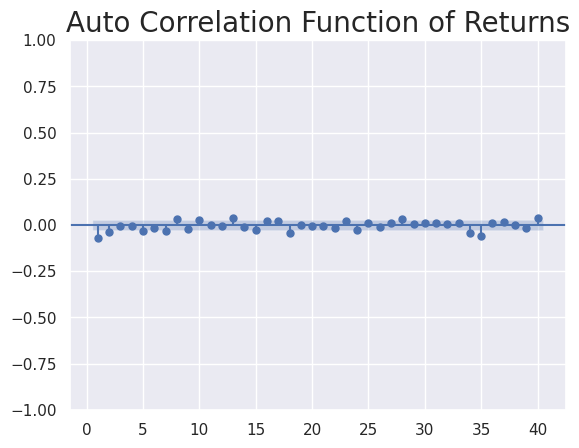

In [73]:
sgt.plot_acf(df_train.returns, lags = 40, zero = False) 
plt.title("Auto Correlation Function of Returns", size = 20)
plt.show()

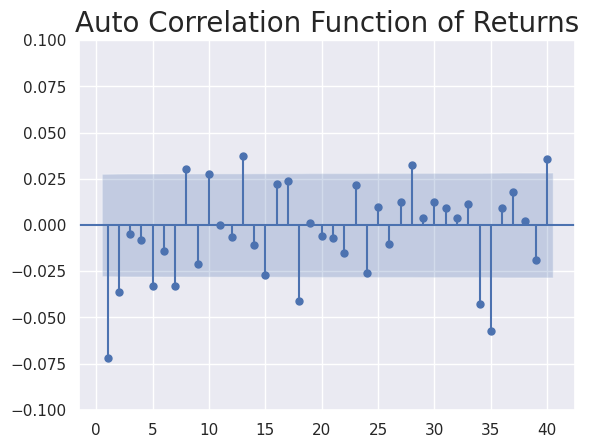

In [74]:
sgt.plot_acf(df_train.returns, lags = 40, zero = False) 
plt.ylim(-0.1,0.1)
plt.title("Auto Correlation Function of Returns", size = 20)
plt.show()

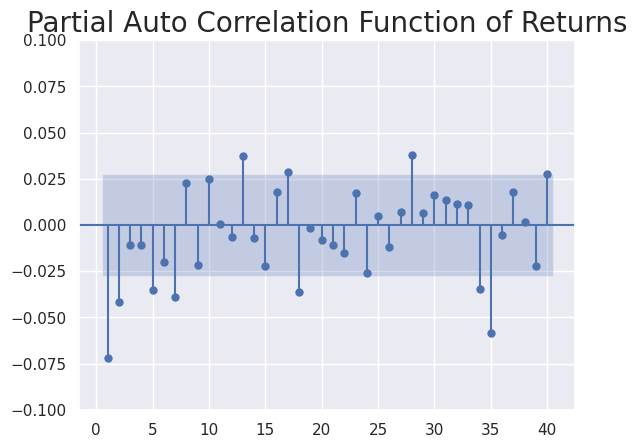

In [75]:
sgt.plot_pacf(df_train.returns, lags = 40, zero = False, method = ('ols')) 
plt.ylim(-0.1,0.1)
plt.title("Partial Auto Correlation Function of Returns", size = 20)
plt.show()

# AR(1) for Returns

In [76]:
model_ret_ar_1 = AutoReg(df_train.returns, lags=1)
results_ret_ar_1 = model_ret_ar_1.fit()
results_ret_ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     AutoReg(1)   Log Likelihood               -8066.009
Method:               Conditional MLE   S.D. of innovations              1.207
Date:                Wed, 20 Mar 2024   AIC                          16138.018
Time:                        15:04:11   BIC                          16157.581
Sample:                    01-11-1994   HQIC                         16144.873
                         - 04-05-2013                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0332      0.017      1.946      0.052      -0.000       0.067
returns.L1    -0.0719      0.014     -5.108      0.000      -0.100      -0.044
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -13.9065           +0.0000j           13.9065            0.5000
-----------------------------------------------------------------------------
"""

# Higher lag AR models for Returns

In [77]:
model_ret_ar_2 = AutoReg(df_train.returns, lags=2)
results_ret_ar_2 = model_ret_ar_2.fit()
results_ret_ar_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     AutoReg(2)   Log Likelihood               -8060.526
Method:               Conditional MLE   S.D. of innovations              1.206
Date:                Wed, 20 Mar 2024   AIC                          16129.051
Time:                        15:04:11   BIC                          16155.134
Sample:                    01-12-1994   HQIC                         16138.191
                         - 04-05-2013                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0346      0.017      2.031      0.042       0.001       0.068
returns.L1    -0.0749      0.014     -5.309      0.000      -0.103      -0.047
returns.L2    -0.0417      0.014     -2.955      0.003      -0.069      -0.014
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.8982           -4.8150j            4.8980           -0.2794
AR.2           -0.8982           +4.8150j            4.8980            0.2794
-----------------------------------------------------------------------------
"""

In [78]:
LLR_test(model_ret_ar_1,model_ret_ar_2)

0.001

In [79]:
model_ret_ar_3 = AutoReg(df_train.returns, lags=3)
results_ret_ar_3 = model_ret_ar_3.fit()
results_ret_ar_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     AutoReg(3)   Log Likelihood               -8059.121
Method:               Conditional MLE   S.D. of innovations              1.206
Date:                Wed, 20 Mar 2024   AIC                          16128.243
Time:                        15:04:12   BIC                          16160.846
Sample:                    01-13-1994   HQIC                         16139.668
                         - 04-05-2013                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0350      0.017      2.052      0.040       0.002       0.068
returns.L1    -0.0753      0.014     -5.336      0.000      -0.103      -0.048
returns.L2    -0.0425      0.014     -3.005      0.003      -0.070      -0.015
returns.L3    -0.0109      0.014     -0.772      0.440      -0.039       0.017
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.8477           -3.9601j            4.0498           -0.2164
AR.2            0.8477           +3.9601j            4.0498            0.2164
AR.3           -5.5959           -0.0000j            5.5959           -0.5000
-----------------------------------------------------------------------------
"""

In [80]:
LLR_test(model_ret_ar_2,model_ret_ar_3)

0.094

In [81]:
model_ret_ar_4 = AutoReg(df_train.returns, lags=4)
results_ret_ar_4 = model_ret_ar_4.fit()
results_ret_ar_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     AutoReg(4)   Log Likelihood               -8057.679
Method:               Conditional MLE   S.D. of innovations              1.206
Date:                Wed, 20 Mar 2024   AIC                          16127.359
Time:                        15:04:12   BIC                          16166.481
Sample:                    01-14-1994   HQIC                         16141.068
                         - 04-05-2013                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0354      0.017      2.077      0.038       0.002       0.069
returns.L1    -0.0754      0.014     -5.344      0.000      -0.103      -0.048
returns.L2    -0.0430      0.014     -3.034      0.002      -0.071      -0.015
returns.L3    -0.0116      0.014     -0.822      0.411      -0.039       0.016
returns.L4    -0.0106      0.014     -0.753      0.452      -0.038       0.017
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7060           -2.5206j            3.0437           -0.1553
AR.2            1.7060           +2.5206j            3.0437            0.1553
AR.3           -2.2535           -2.2535j            3.1869           -0.3750
AR.4           -2.2535           +2.2535j            3.1869            0.3750
-----------------------------------------------------------------------------
"""

In [82]:
LLR_test(model_ret_ar_3,model_ret_ar_4)

0.089

In [83]:
model_ret_ar_5 = AutoReg(df_train.returns, lags=5)
results_ret_ar_5 = model_ret_ar_5.fit()
results_ret_ar_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     AutoReg(5)   Log Likelihood               -8053.355
Method:               Conditional MLE   S.D. of innovations              1.206
Date:                Wed, 20 Mar 2024   AIC                          16120.710
Time:                        15:04:12   BIC                          16166.352
Sample:                    01-17-1994   HQIC                         16136.704
                         - 04-05-2013                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0366      0.017      2.146      0.032       0.003       0.070
returns.L1    -0.0758      0.014     -5.371      0.000      -0.103      -0.048
returns.L2    -0.0434      0.014     -3.065      0.002      -0.071      -0.016
returns.L3    -0.0131      0.014     -0.928      0.353      -0.041       0.015
returns.L4    -0.0134      0.014     -0.944      0.345      -0.041       0.014
returns.L5    -0.0354      0.014     -2.508      0.012      -0.063      -0.008
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4734           -1.2694j            1.9448           -0.1132
AR.2            1.4734           +1.2694j            1.9448            0.1132
AR.3           -0.6626           -1.8158j            1.9329           -0.3057
AR.4           -0.6626           +1.8158j            1.9329            0.3057
AR.5           -1.9991           -0.0000j            1.9991           -0.5000
-----------------------------------------------------------------------------
"""

In [84]:
LLR_test(model_ret_ar_4,model_ret_ar_5)

0.003

In [85]:
model_ret_ar_6 = AutoReg(df_train.returns, lags=6)
results_ret_ar_6 = model_ret_ar_6.fit()
results_ret_ar_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     AutoReg(6)   Log Likelihood               -8051.191
Method:               Conditional MLE   S.D. of innovations              1.205
Date:                Wed, 20 Mar 2024   AIC                          16118.382
Time:                        15:04:12   BIC                          16170.542
Sample:                    01-18-1994   HQIC                         16136.661
                         - 04-05-2013                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0374      0.017      2.193      0.028       0.004       0.071
returns.L1    -0.0765      0.014     -5.418      0.000      -0.104      -0.049
returns.L2    -0.0437      0.014     -3.085      0.002      -0.071      -0.016
returns.L3    -0.0134      0.014     -0.947      0.344      -0.041       0.014
returns.L4    -0.0143      0.014     -1.006      0.314      -0.042       0.014
returns.L5    -0.0369      0.014     -2.606      0.009      -0.065      -0.009
returns.L6    -0.0202      0.014     -1.431      0.152      -0.048       0.007
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4000           -1.0250j            1.7351           -0.1006
AR.2            1.4000           +1.0250j            1.7351            0.1006
AR.3           -0.2986           -1.8163j            1.8407           -0.2759
AR.4           -0.2986           +1.8163j            1.8407            0.2759
AR.5           -2.0139           -0.8917j            2.2025           -0.4337
AR.6           -2.0139           +0.8917j            2.2025            0.4337
-----------------------------------------------------------------------------
"""

In [86]:
LLR_test(model_ret_ar_5,model_ret_ar_6)

0.037

**Let's take the simpler model model_ret_ar_5**

# Normalizing values

In [87]:
benchmark = df_train.spx.iloc[0]

In [88]:
df_train['norm'] = df_train.spx.div(benchmark).mul(100)

In [89]:
sts.adfuller(df_train.norm)

(-1.7396871077371305,
 0.4107891338207861,
 18,
 5001,
 {'1%': -3.431658270286891,
  '5%': -2.8621181140235223,
  '10%': -2.5670777307913744},
 24351.278699350325)

**Normalizing did not make it stationary. Hence, we can't use AR models.**

In [90]:
bench_ret = df_train.returns.iloc[0]
df_train['norm_ret'] = df_train.returns.div(bench_ret).mul(100)
sts.adfuller(df_train.norm_ret)

(-17.034457190981218,
 8.280537020316351e-30,
 17,
 5002,
 {'1%': -3.431658008603046,
  '5%': -2.862117998412982,
  '10%': -2.567077669247375},
 60636.5822032878)

**This data is stationary.**

# Normalized Returns

In [91]:
model_norm_ret_ar_1 = AutoReg(df_train.returns, lags=1)
results_norm_ret_ar_1 = model_norm_ret_ar_1.fit()
results_norm_ret_ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     AutoReg(1)   Log Likelihood               -8066.009
Method:               Conditional MLE   S.D. of innovations              1.207
Date:                Wed, 20 Mar 2024   AIC                          16138.018
Time:                        15:04:14   BIC                          16157.581
Sample:                    01-11-1994   HQIC                         16144.873
                         - 04-05-2013                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0332      0.017      1.946      0.052      -0.000       0.067
returns.L1    -0.0719      0.014     -5.108      0.000      -0.100      -0.044
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -13.9065           +0.0000j           13.9065            0.5000
-----------------------------------------------------------------------------
"""

**The normalized AR(1) model gives the same lag coefficients as a non-normalized AR(1) model. Only the constant changes. So we can conclude that normalization has no effect on model selection.**

# Analyzing the residuals

In [92]:
df_train['res_prices'] = results_ar_8.resid

In [93]:
df_train.res_prices.mean()

3.692611081592286e-13

In [94]:
df_train.res_prices.var()

173.7409104402988

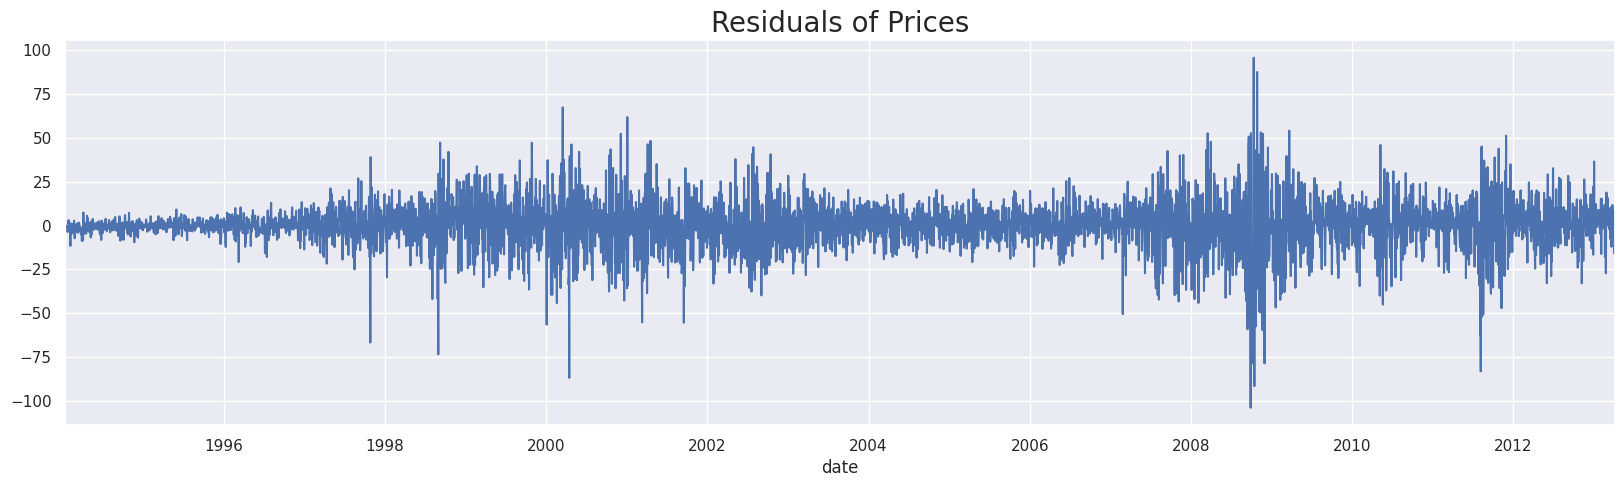

In [95]:
df_train.res_prices[1:].plot(figsize = (20,5))
plt.title("Residuals of Prices", size = 20)
plt.show()

In [96]:
df_train['res_ret'] = results_ret_ar_5.resid 

In [97]:
df_train.res_ret.mean()

9.209427283032206e-18

In [98]:
df_train.res_ret.var()

1.4535797297371096

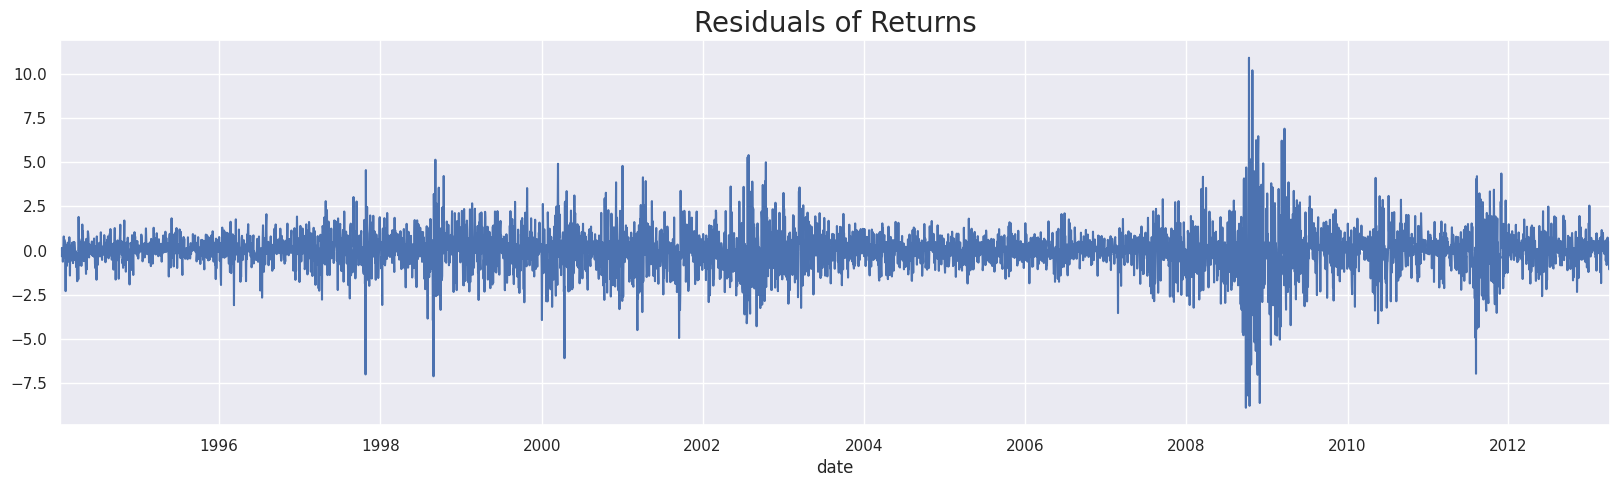

In [99]:
df_train.res_ret[1:].plot(figsize = (20,5))
plt.title("Residuals of Returns", size = 20)
plt.show()